In [1]:
import numpy as np
import pandas as pd

In [2]:
df = pd.read_csv("../data/bangkok_traffy.csv")

In [3]:
df = df.drop(['organization','comment','photo','photo_after','coords','address','star','count_reopen'],axis=1)

In [4]:
df.head()

,ticket_id,type,subdistrict,district,province,timestamp,state,last_activity
0,2021-9LHDM6,{},บางพลัด,บางพลัด,กรุงเทพมหานคร,2021-09-01 10:44:55.353209+00,กำลังดำเนินการ,2022-02-22 04:59:58.622268+00
1,2021-FYJTFP,{ความสะอาด},NaN,NaN,กรุงเทพมหานคร,2021-09-03 12:51:09.453003+00,เสร็จสิ้น,2022-06-04 15:34:14.609206+00
2,2021-8GKAR9,{สายไฟ},สามเสนนอก,ห้วยขวาง,จังหวัดกรุงเทพมหานคร,2021-09-19 06:47:50.488685+00,กำลังดำเนินการ,2022-02-22 04:30:07.293416+00
3,2021-AFPUXZ,"{ถนน,สะพาน}",สีลม,บางรัก,กรุงเทพมหานคร,2021-09-19 07:40:30.000781+00,กำลังดำเนินการ,2022-02-22 04:30:04.507406+00
4,2021-CGPMUN,"{น้ำท่วม,ร้องเรียน}",หนองบอน,ประเวศ,กรุงเทพมหานคร,2021-09-19 14:56:08.924992+00,เสร็จสิ้น,2022-06-21 08:21:09.532782+00


In [5]:
df.isna().sum()

ticket_id        2658
type               97
subdistrict        72
district           74
province           25
timestamp           0
state               0
last_activity       0
dtype: int64

In [6]:
df['province'].unique()

array(['กรุงเทพมหานคร', 'จังหวัดกรุงเทพมหานคร', 'นนทบุรี', 'นครปฐม',
       'ศรีสะเกษ', 'สมุทรปราการ', 'เชียงใหม่', 'ปทุมธานี', 'สมุทรสาคร',
       'อ่างทอง', 'ชลบุรี', 'ภูเก็ต', 'ยะลา', 'ลำปาง', 'พระนครศรีอยุธยา',
       'ตาก', 'อุบลราชธานี', 'ฉะเชิงเทรา', 'ขอนแก่น', 'นครศรีธรรมราช',
       'เชียงราย', nan, 'จันทบุรี', 'สงขลา', 'นครราชสีมา', 'ปราจีนบุรี',
       'กาฬสินธุ์', 'พิจิตร', 'อุตรดิตถ์', 'ราชบุรี', 'กาญจนบุรี',
       'ชัยนาท', 'อุทัยธานี', 'สุพรรณบุรี', 'ลพบุรี', 'นครสวรรค์',
       'นครนายก', 'สกลนคร', 'สตูล', 'อุดรธานี', 'เพชรบุรี', 'ตรัง',
       'สุรินทร์', 'อำนาจเจริญ', 'บุรีรัมย์', 'สุโขทัย', 'สุราษฎร์ธานี',
       'พิษณุโลก', 'มหาสารคาม', 'ร้อยเอ็ด', 'แพร่', 'สมุทรสงคราม',
       'สิงห์บุรี', 'ลำพูน', 'ระยอง', 'ยโสธร', 'นครพนม', 'น่าน',
       'หนองบัวลำภู', 'จังหวัดชลบุรี', 'จังหวัดจังหวัด กรุงเทพมหานคร',
       'จังหวัดพระนครศรีอยุธยา', 'จังหวัดสมุทรปราการ', 'จังหวัดLac',
       'จังหวัดฉะเชิงเทรา', 'จังหวัดนนทบุรี', 'จังหวัดBangkok',
       'จังหวัดจังหวัดกรุงเทพม

In [7]:
df = df[df['province'].str.contains('กรุงเทพ|bangkok',na=False,case=False)]

In [8]:
# df[df['type']=='{}'].time.value_counts()

In [9]:
df = df.dropna(subset=['subdistrict', 'district'] )

In [10]:
df.isna().sum()

ticket_id        2633
type               97
subdistrict         0
district            0
province            0
timestamp           0
state               0
last_activity       0
dtype: int64

In [11]:
df = df[df['state'].str.contains('เสร็จ',na=False,case=False)]

In [12]:
df.type.unique()

array(['{น้ำท่วม,ร้องเรียน}', '{สะพาน}', '{น้ำท่วม,ถนน}', ...,
       '{ถนน,จราจร,เสนอแนะ,ห้องน้ำ}',
       '{คนจรจัด,ความสะอาด,กีดขวาง,ทางเท้า,ร้องเรียน}',
       '{ถนน,ทางเท้า,PM2.5,ความปลอดภัย}'], dtype=object)

In [13]:
df.district.value_counts()

จตุจักร              10049
ประเวศ                8858
บางแค                 7816
บางเขน                6872
ลาดกระบัง             6615
บางกะปิ               6555
วัฒนา                 6406
คลองเตย               6080
สวนหลวง               5745
บางขุนเทียน           5136
บึงกุ่ม               4895
บางซื่อ               4719
ราชเทวี               4582
ปทุมวัน               4567
ดินแดง                4443
บางกอกน้อย            4360
ลาดพร้าว              4308
สาทร                  4292
บางรัก                4262
วังทองหลาง            4217
พญาไท                 4060
ธนบุรี                3986
บางนา                 3819
สายไหม                3797
พระนคร                3755
คลองสามวา             3735
มีนบุรี               3572
ห้วยขวาง              3481
บางพลัด               3434
ภาษีเจริญ             3426
สะพานสูง              3259
หนองจอก               3255
พระโขนง               3194
หลักสี่               3188
ดอนเมือง              3146
จอมทอง                3145
ตลิ่งชัน              2874
ท

In [14]:
df[['subdistrict','district']]

,subdistrict,district
4,หนองบอน,ประเวศ
10,ยานนาวา,สาทร
25,ลาดพร้าว,ลาดพร้าว
64,ลาดพร้าว,ลาดพร้าว
102,ดุสิต,ดุสิต
...,...,...
270961,สีลม,บางรัก
270979,ทุ่งครุ,ทุ่งครุ
271016,ประเวศ,ประเวศ
271018,บางยี่ขัน,บางพลัด


In [15]:
df['timestamp'] = pd.to_datetime(df['timestamp'], utc=True)
df['last_activity'] = pd.to_datetime(df['last_activity'], utc=True)

In [16]:
df['time'] =  (df['last_activity'] - df['timestamp']).dt.days

In [17]:
type_con = df['type'].str.strip('{}').str.get_dummies(',')

In [18]:
df = pd.concat([df,type_con],axis=1)

In [19]:
district_hot =  pd.get_dummies(df['district'])

In [20]:
df = pd.concat([df,district_hot],axis=1)

In [21]:
df = df.drop(['ticket_id','type','subdistrict','district','province','timestamp','state','last_activity'],axis=1)

In [22]:
df[['time']].describe()

,time
count,202773.000000
mean,43.205284
std,69.637659
min,0.000000
25%,1.000000
50%,8.000000
75%,52.000000
max,464.000000


<AxesSubplot:xlabel='time', ylabel='Density'>

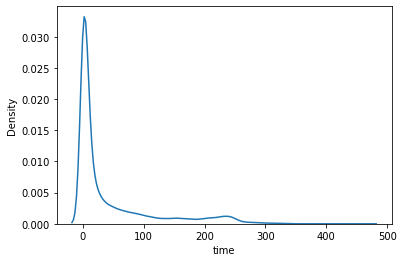

In [23]:
import seaborn as sns
sns.kdeplot(data=df, x="time")

In [24]:
# Q1 = df['time'].quantile(0.25)
# Q3 = df['time'].quantile(0.75)
# IQR = Q3 - Q1
# df = df.query('(@Q1 - 1.5 * @IQR) <= time <= (@Q3 + 1.5 * @IQR)')

In [25]:
df[['time']].describe()

,time
count,202773.000000
mean,43.205284
std,69.637659
min,0.000000
25%,1.000000
50%,8.000000
75%,52.000000
max,464.000000


<AxesSubplot:xlabel='time', ylabel='Density'>

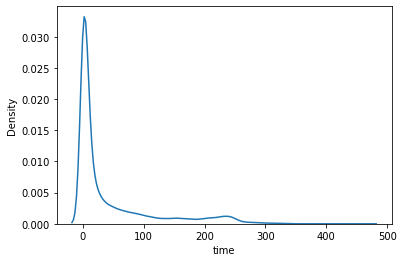

In [26]:
sns.kdeplot(data=df, x="time")

In [27]:
from sklearn.model_selection import train_test_split

df_train, df_rem = train_test_split(df, test_size=0.3, random_state=123)

df_val, df_test = train_test_split(df_rem, test_size=0.5, random_state=123)


In [28]:
df_train.describe()

,time,PM2.5,การเดินทาง,กีดขวาง,คนจรจัด,คลอง,ความปลอดภัย,ความสะอาด,จราจร,ต้นไม้,...,วัฒนา,สวนหลวง,สะพานสูง,สัมพันธวงศ์,สาทร,สายไหม,หนองจอก,หนองแขม,หลักสี่,ห้วยขวาง
count,141941.000000,141941.000000,141941.000000,141941.000000,141941.000000,141941.000000,141941.000000,141941.000000,141941.000000,141941.000000,...,141941.00000,141941.000000,141941.000000,141941.000000,141941.000000,141941.000000,141941.000000,141941.000000,141941.000000,141941.000000
mean,43.120945,0.004093,0.001494,0.061850,0.003973,0.033359,0.064738,0.089777,0.040453,0.034564,...,0.03145,0.028547,0.015929,0.005502,0.021262,0.018712,0.016197,0.013203,0.015612,0.016782
std,69.626614,0.063848,0.038618,0.240883,0.062910,0.179573,0.246064,0.285863,0.197021,0.182673,...,0.17453,0.166530,0.125202,0.073973,0.144258,0.135506,0.126233,0.114142,0.123970,0.128453
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,52.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,464.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [29]:
df_val[['time']].describe()

,time
count,30416.000000
mean,43.162612
std,69.541379
min,0.000000
25%,1.000000
50%,8.000000
75%,52.000000
max,377.000000


In [30]:
Q1 = df_train['time'].quantile(0.25)
Q3 = df_train['time'].quantile(0.75)
IQR = Q3 - Q1
df_train = df_train.query('(@Q1 - 1.5 * @IQR) <= time <= (@Q3 + 1.5 * @IQR)')

In [31]:
df_train[['time']].describe()

,time
count,123694.000000
mean,19.300039
std,29.196575
min,0.000000
25%,1.000000
50%,5.000000
75%,24.000000
max,128.000000


# Model

In [32]:
import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tqdm import tqdm

class TabularDataset(Dataset):
    def __init__(self, dataframe, feature_scaler, target_scaler):
        self.data = dataframe.to_numpy()
        self.feature_scaler = feature_scaler
        self.target_scaler = target_scaler
        self.targets = self.target_scaler.transform(self.data[:, 0].reshape(-1, 1))
        self.features = self.feature_scaler.transform(self.data[:, 1:])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x = torch.tensor(self.features[idx], dtype=torch.float32)
        y = torch.tensor(self.targets[idx], dtype=torch.float32)
        return x, y

In [33]:
feature_scaler = MinMaxScaler()
feature_scaler.fit(df_train.iloc[:, 1:])

target_scaler = MinMaxScaler()
target_scaler.fit(df_train.iloc[:, 0].values.reshape(-1, 1))

MinMaxScaler()

In [34]:
train_dataset = TabularDataset(df_train, feature_scaler, target_scaler)
val_dataset = TabularDataset(df_val, feature_scaler, target_scaler)
test_dataset = TabularDataset(df_test, feature_scaler, target_scaler)


train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

c:\Users\pacha\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\Users\pacha\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\Users\pacha\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [35]:
import torch.nn as nn
import torch.nn.functional as F

class TabularModel(torch.nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.fc1 = torch.nn.Linear(input_size, 256)
        self.fc2 = torch.nn.Linear(256, 128)
        self.fc3 = torch.nn.Linear(128, 1)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

In [36]:
train_dataset[0]

(tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]),
 tensor([0.2422]))

In [37]:
model = TabularModel(input_size=df_train.shape[1]-1)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [38]:
import matplotlib.pyplot as plt

EPOCHS = 5
train_losses = []
test_losses = []

for epoch in range(EPOCHS):
    train_loss = 0.0
    for (inputs, targets) in tqdm(train_loader):
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    test_loss = 0.0
    for (inputs, targets) in tqdm(val_loader):
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        test_loss += loss.item()
    test_loss /= len(test_loader)
    test_losses.append(test_loss)
    
    print(f'Epoch {epoch+1}, Train Loss: {train_loss:.6f}, Test Loss: {test_loss:.6f}')

100%|██████████| 476/476 [00:00<00:00, 633.82it/s]


Epoch 1, Train Loss: 0.051181, Test Loss: 0.309023


100%|██████████| 476/476 [00:00<00:00, 665.73it/s]


Epoch 2, Train Loss: 0.049274, Test Loss: 0.308601


100%|██████████| 476/476 [00:05<00:00, 83.03it/s] 


Epoch 3, Train Loss: 0.048931, Test Loss: 0.306175


100%|██████████| 476/476 [00:00<00:00, 602.43it/s]


Epoch 4, Train Loss: 0.048582, Test Loss: 0.304904


100%|██████████| 476/476 [00:00<00:00, 666.15it/s]

Epoch 5, Train Loss: 0.048414, Test Loss: 0.308736


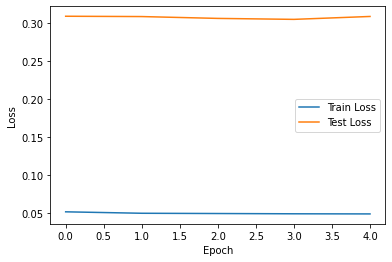

In [39]:
# Plotting the loss
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [40]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

import pandas as pd

def evaluate_model(model, dataloader, feature_scaler, target_scaler):
    criterion = torch.nn.MSELoss()
    model.eval()
    total_loss = 0.0
    y_true = []
    y_pred = []
    with torch.no_grad():
        for inputs, targets in dataloader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            total_loss += loss.item()
            y_true.extend(targets.numpy())
            y_pred.extend(outputs.numpy())
    
    # Inverse transform the scaled values
    y_true = target_scaler.inverse_transform(y_true)
    y_pred = target_scaler.inverse_transform(y_pred)
    
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    
    df = pd.DataFrame({'Actual': y_true.flatten(), 'Predicted': y_pred.flatten()})
    
    return mse, mae, rmse, df

In [41]:
train_mse, train_mae, train_rmse, results_df = evaluate_model(model, train_loader, feature_scaler, target_scaler)
print(f'Train MSE: {train_mse:.4f}')
print(f'Train MAE: {train_mae:.4f}')
print(f'Train RMSE: {train_rmse:.4f}')

results_df.head()

Train MSE: 782.6289
Train MAE: 19.7239
Train RMSE: 27.9755


,Actual,Predicted
0,18.0,12.661202
1,9.0,5.724831
2,96.0,17.160513
3,0.0,14.242009
4,5.0,12.422805


In [42]:
# Usage:
test_mse, test_mae, test_rmse, results_df = evaluate_model(model, test_loader, feature_scaler, target_scaler)
print(f'Test MSE: {test_mse:.4f}')
print(f'Test MAE: {test_mae:.4f}')
print(f'Test RMSE: {test_rmse:.4f}')

results_df.head()  # Print the first few rows of the results DataFrame

Test MSE: 5115.0719
Test MAE: 40.5730
Test RMSE: 71.5197


,Actual,Predicted
0,0.0,13.701287
1,212.0,18.313210
2,115.0,13.609630
3,1.0,13.482587
4,2.0,18.222828


In [43]:
results_df.describe()

,Actual,Predicted
count,30416.000000,30416.000000
mean,43.641537,18.742485
std,69.785929,8.184123
min,0.000000,-0.495570
25%,1.000000,13.262754
50%,8.000000,17.966469
75%,53.000000,22.508884
max,345.000000,58.468353
